## Задание
* Разработать knn-классификатор для набора данных, указанного в варианте методических указаний (для задания 1).
* Разбить выборку на обучающую и тестовую.
* Обучить, проверить качество классификатора на обучающей и тестовой выборках: рассчитать общую точность, Recall, Precision, F1-measure.
* Рассмотреть различное число ближайших соседей, различные метрики для вычисления расстояний между объектами, различные правила голосования. Перебор по сетке (grid search).
* Выбрать лучший классификатор.
* Выполнить визуализацию с помощью t-sne и UMAP (при различных сочетаниях значений их параметров): изобразить объекты разных классов разным цветом (разным маркерами).
* Сделать рисунки разбиения на классы на основе выборок с известными метками классов и рисунки разбиения на классы с метками выставленными классификатором.

## Подготовка данных
Импортируем необходимые библиотеки

In [1]:
import warnings
import csv
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import umap
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from ast import literal_eval
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
sns.set_palette('husl')
warnings.filterwarnings("ignore")

Загружаем и подготавливаем датасет.

In [2]:
data = pd.read_csv('../Data/hepatitis.data', index_col=False, names=['Class', 'Age', 'Sex', 'Steroid', 'Antivrals', 'Fatigue', 'Malaise', 'Anorexia',
                                                                     'Liver big', 'Liver firm', 'Spleen palpable', 'Spiders', 'Ascites', 'Varices', 'Bilirubin', 'Alk phosphate', 'Sgot', 'Albumin', 'Protime', 'Histology'])

x = data.drop(['Class'], axis=1)
y = data['Class']

x = x.replace('?', np.nan)
y = y.replace(1, 0)
y = y.replace(2, 1)
for (colName, colData) in x.iteritems():
    x[colName] = x[colName].astype(float)
    x[colName] = x[colName].fillna(x[colName].mean())
scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)

Задаем параметры для **gridSearch**

In [3]:
neighbours = [i+1 for i in range(1, 15)]
algorithm = ['ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

Разбиваем выборку на обучающую и тестовую в соотношении.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
knn_model = KNeighborsClassifier()

## Перебор параметров по сетке
С помощью модуля gridsearch производим подбор наилучших параметров для нашего алгоритма.

In [5]:
gs_clf = GridSearchCV(knn_model, param_grid={'n_neighbors': neighbours, 'algorithm': algorithm,
                                             'weights': weights, 'metric': metric})
gs_clf.fit(x_train, y_train)
best_cv_err = 1 - gs_clf.best_score_
best_param_neighbours = gs_clf.best_estimator_.n_neighbors
best_param_algorithm = gs_clf.best_estimator_.algorithm
best_param_weights = gs_clf.best_estimator_.weights
best_param_metric = gs_clf.best_estimator_.metric

## Создание модели с наилучшими параметрами
Выводим значения наилучших параметров и создаем на их основе модель KNN-классификатора.

In [6]:
print(f'Ошибка перекрёстного контроля: {best_cv_err}')
print(f'Наилучшее значение параметра neighbours: {best_param_neighbours}')
print(f'Наилучшее значение параметра algorithm: {best_param_algorithm}')
print(f'Наилучшее значение параметра weights: {best_param_weights}')
print(f'Наилучшее значение параметра metric: {best_param_metric}')

knn_model = KNeighborsClassifier(n_neighbors=best_param_neighbours, algorithm=best_param_algorithm,
                                 weights=best_param_weights, metric=best_param_metric)
knn_model.fit(x_train, y_train)
err_train = np.mean(y_train != knn_model.predict(x_train))
err_test = np.mean(y_test != knn_model.predict(x_test))
print(f'Ошибка на обучающей выборке: {err_train}')
print(f'Ошибка на тестовой выборке: {err_test}')

y_pred = knn_model.predict(x_test)
print(classification_report(y_test, y_pred))

Ошибка перекрёстного контроля: 0.12034632034632031
Наилучшее значение параметра neighbours: 8
Наилучшее значение параметра algorithm: ball_tree
Наилучшее значение параметра weights: uniform
Наилучшее значение параметра metric: euclidean
Ошибка на обучающей выборке: 0.12962962962962962
Ошибка на тестовой выборке: 0.14893617021276595
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.92      0.89      0.90        37

    accuracy                           0.85        47
   macro avg       0.78      0.80      0.79        47
weighted avg       0.86      0.85      0.85        47



## Построение диаграмм размаха для каждого параметра
На графиках показана степень разброса и значения параметров **gridSearch**

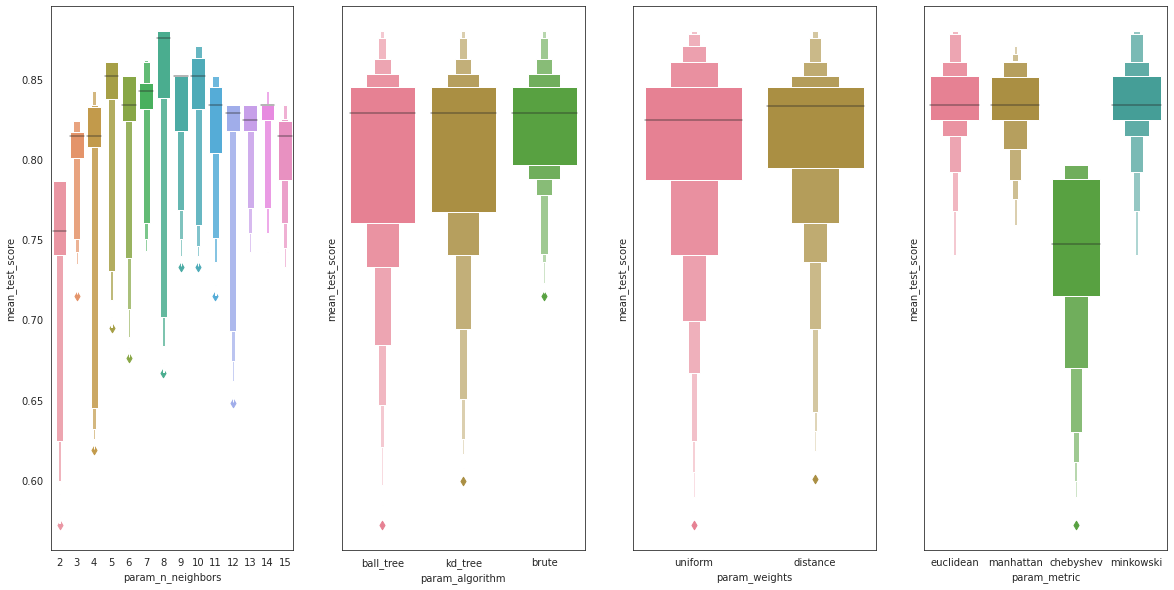

In [7]:
grsh_results = pd.DataFrame(data=gs_clf.cv_results_)
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 10))
sns.boxenplot(x=grsh_results['param_n_neighbors'], y=grsh_results['mean_test_score'], ax=axs[0])
sns.boxenplot(x=grsh_results['param_algorithm'], y=grsh_results['mean_test_score'], ax=axs[1])
sns.boxenplot(x=grsh_results['param_weights'], y=grsh_results['mean_test_score'], ax=axs[2])
sns.boxenplot(x=grsh_results['param_metric'], y=grsh_results['mean_test_score'], ax=axs[3])

## Построение матрицы ошибок

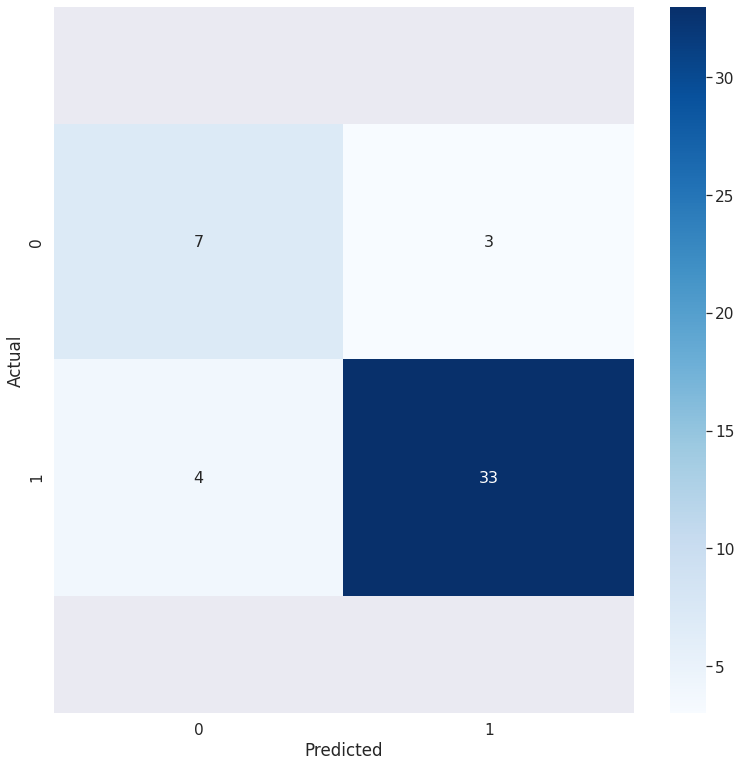

In [8]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13, 13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})
i, k = ax.get_ylim()
ax = ax.set_ylim(i+0.5, k-0.5)

## T-SNE

### Perplexity

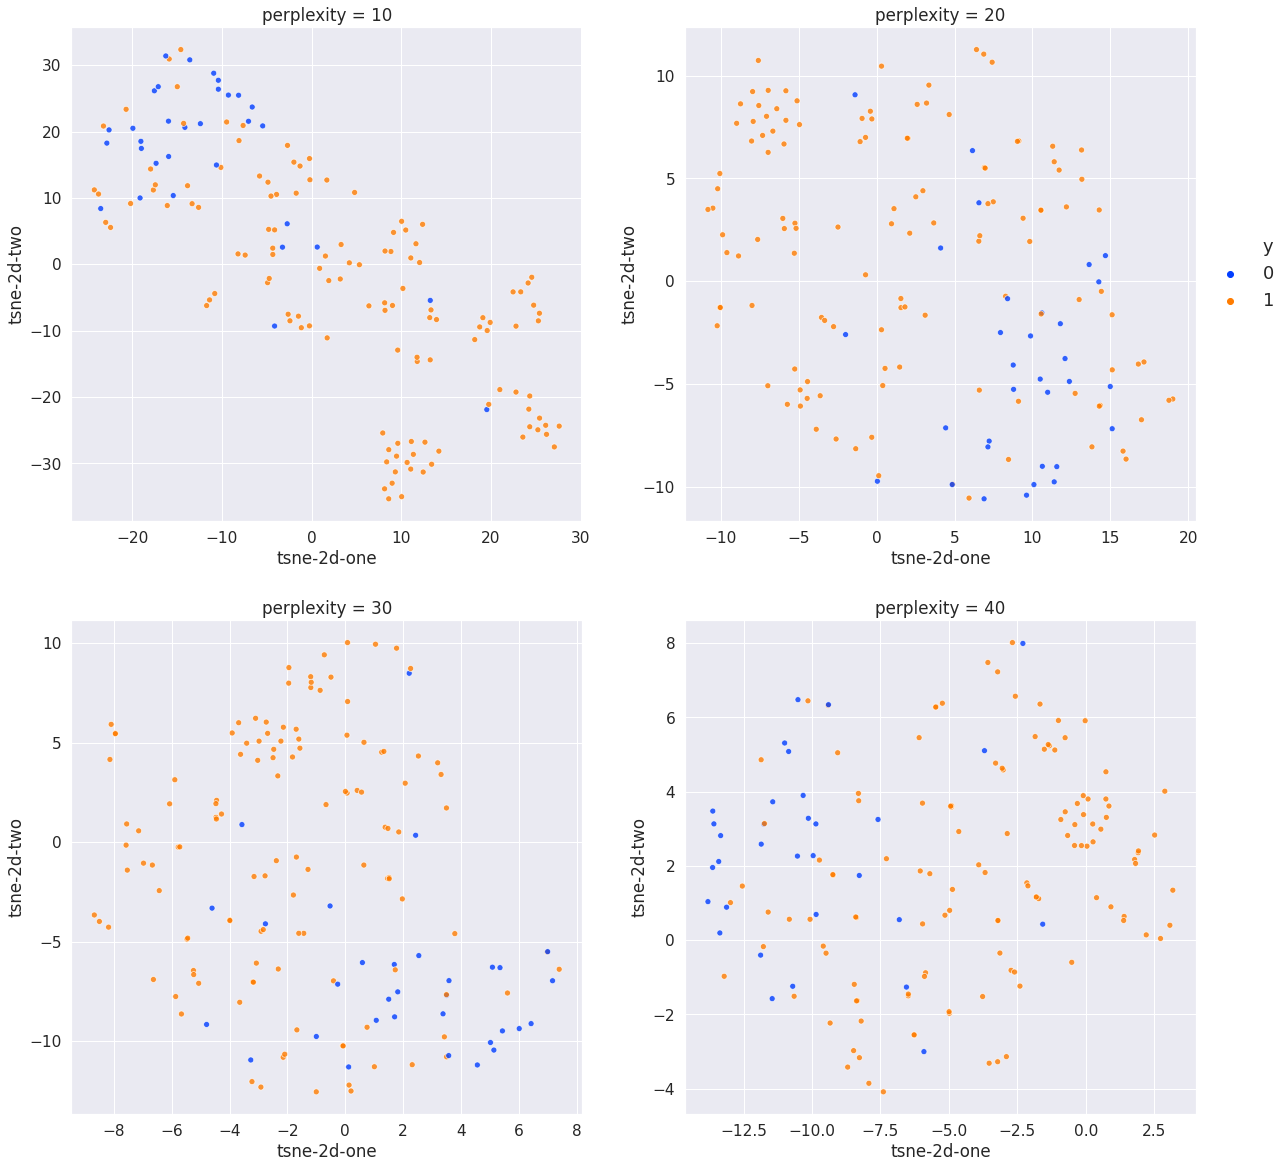

In [9]:
p = [10, 20, 30, 40]
arr = []
for elem in p:
    x_embedded = TSNE(n_components=2, perplexity=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(25, 20))
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("perplexity = 10")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(2, 2, 2)
ax2.set_title("perplexity = 20")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(2, 2, 3)
ax3.set_title("perplexity = 30")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(2, 2, 4)
ax4.set_title("perplexity = 40")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

### Learning rate

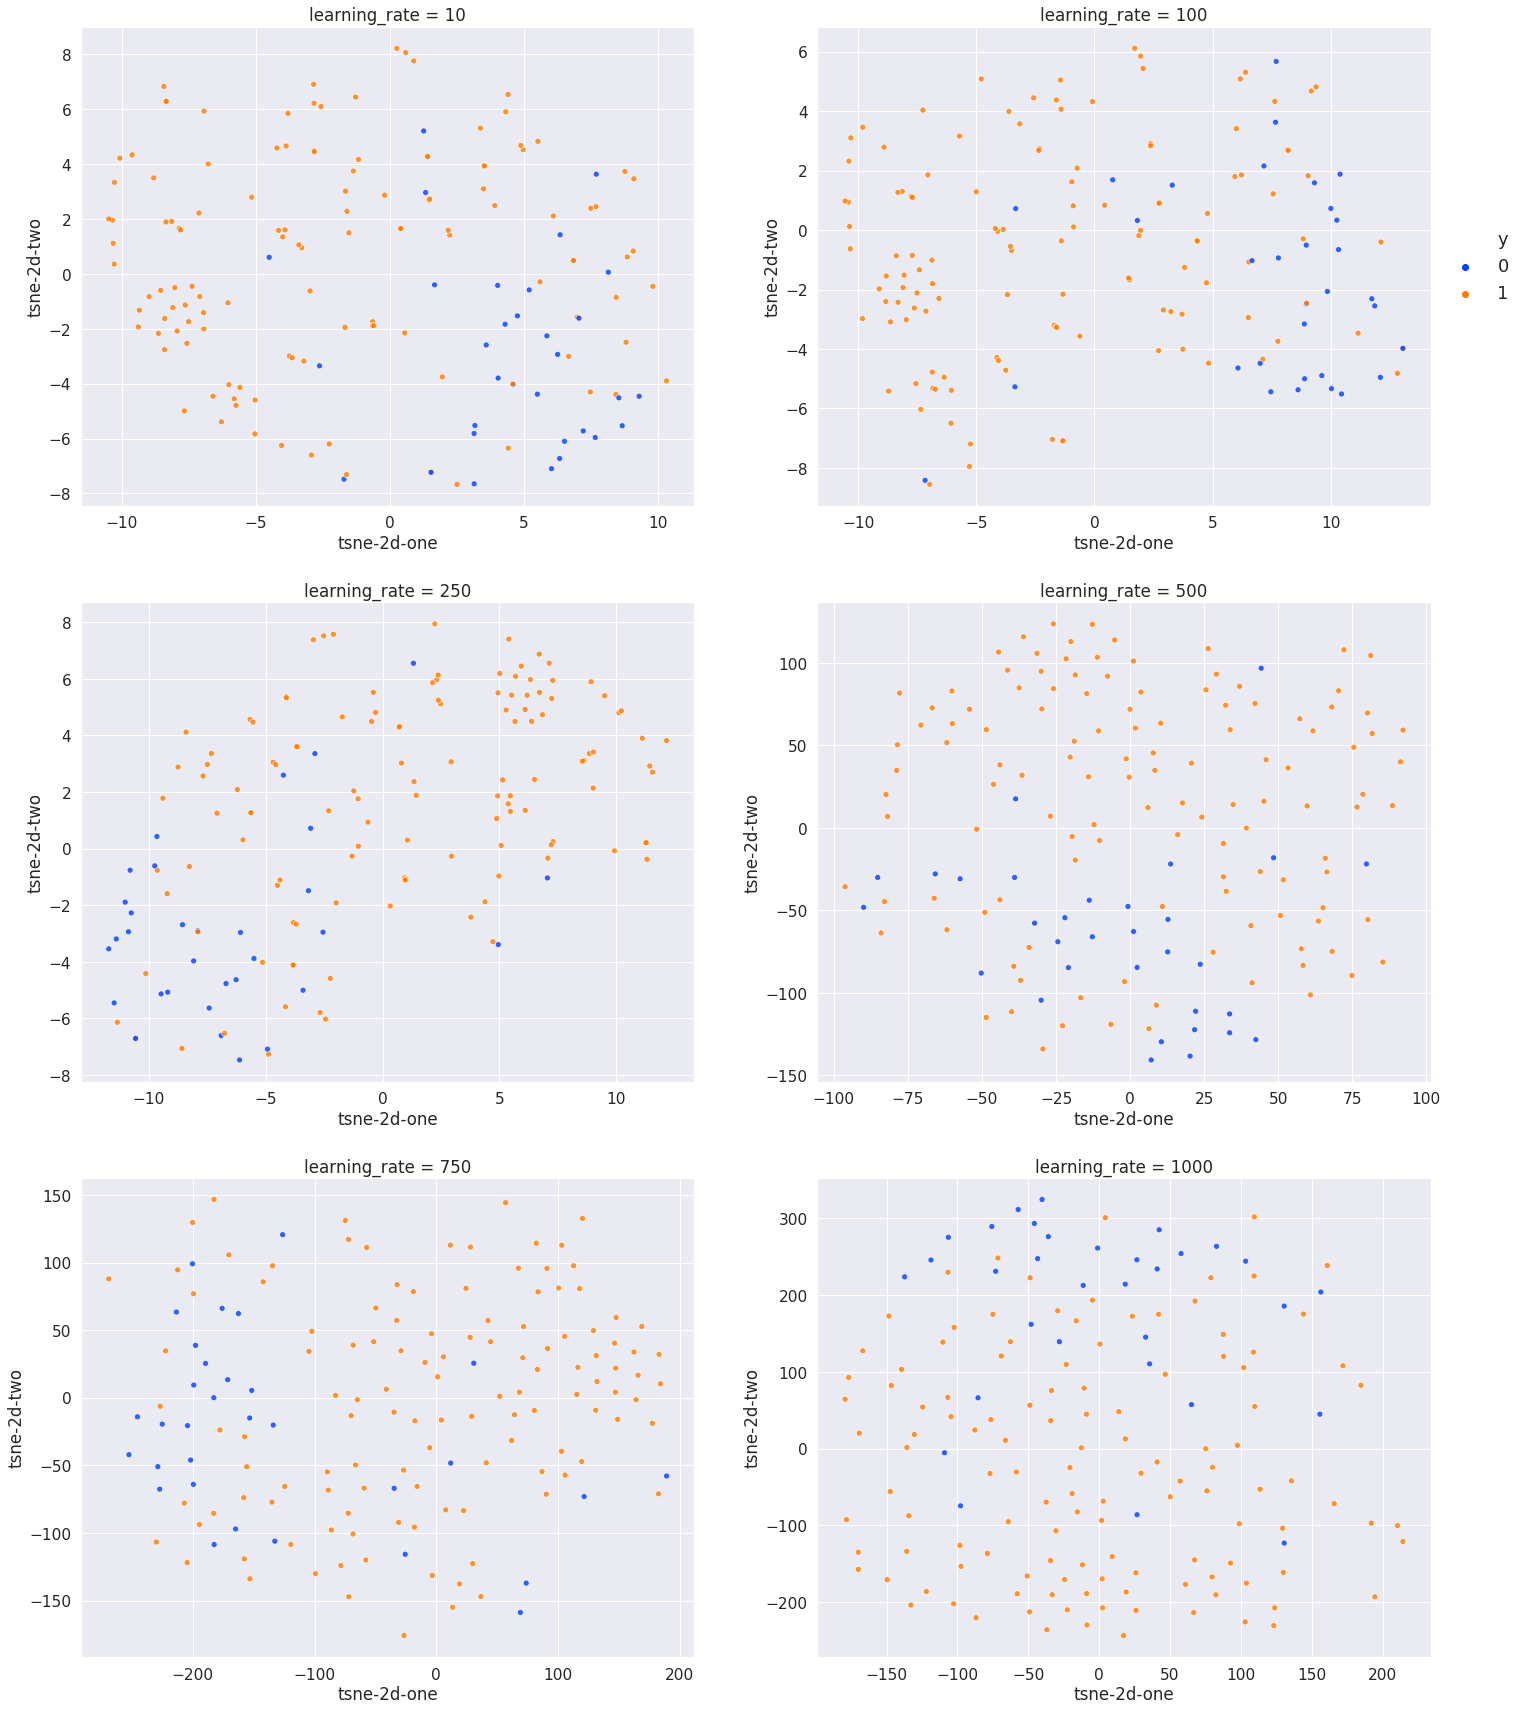

In [10]:
lr = [10, 100, 250, 500, 750, 1000]
arr = []
for elem in lr:
    x_embedded = TSNE(n_components=2, learning_rate=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("learning_rate = 10")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("learning_rate = 100")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("learning_rate = 250")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("learning_rate = 500")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("learning_rate = 750")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("learning_rate = 1000")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Metrics

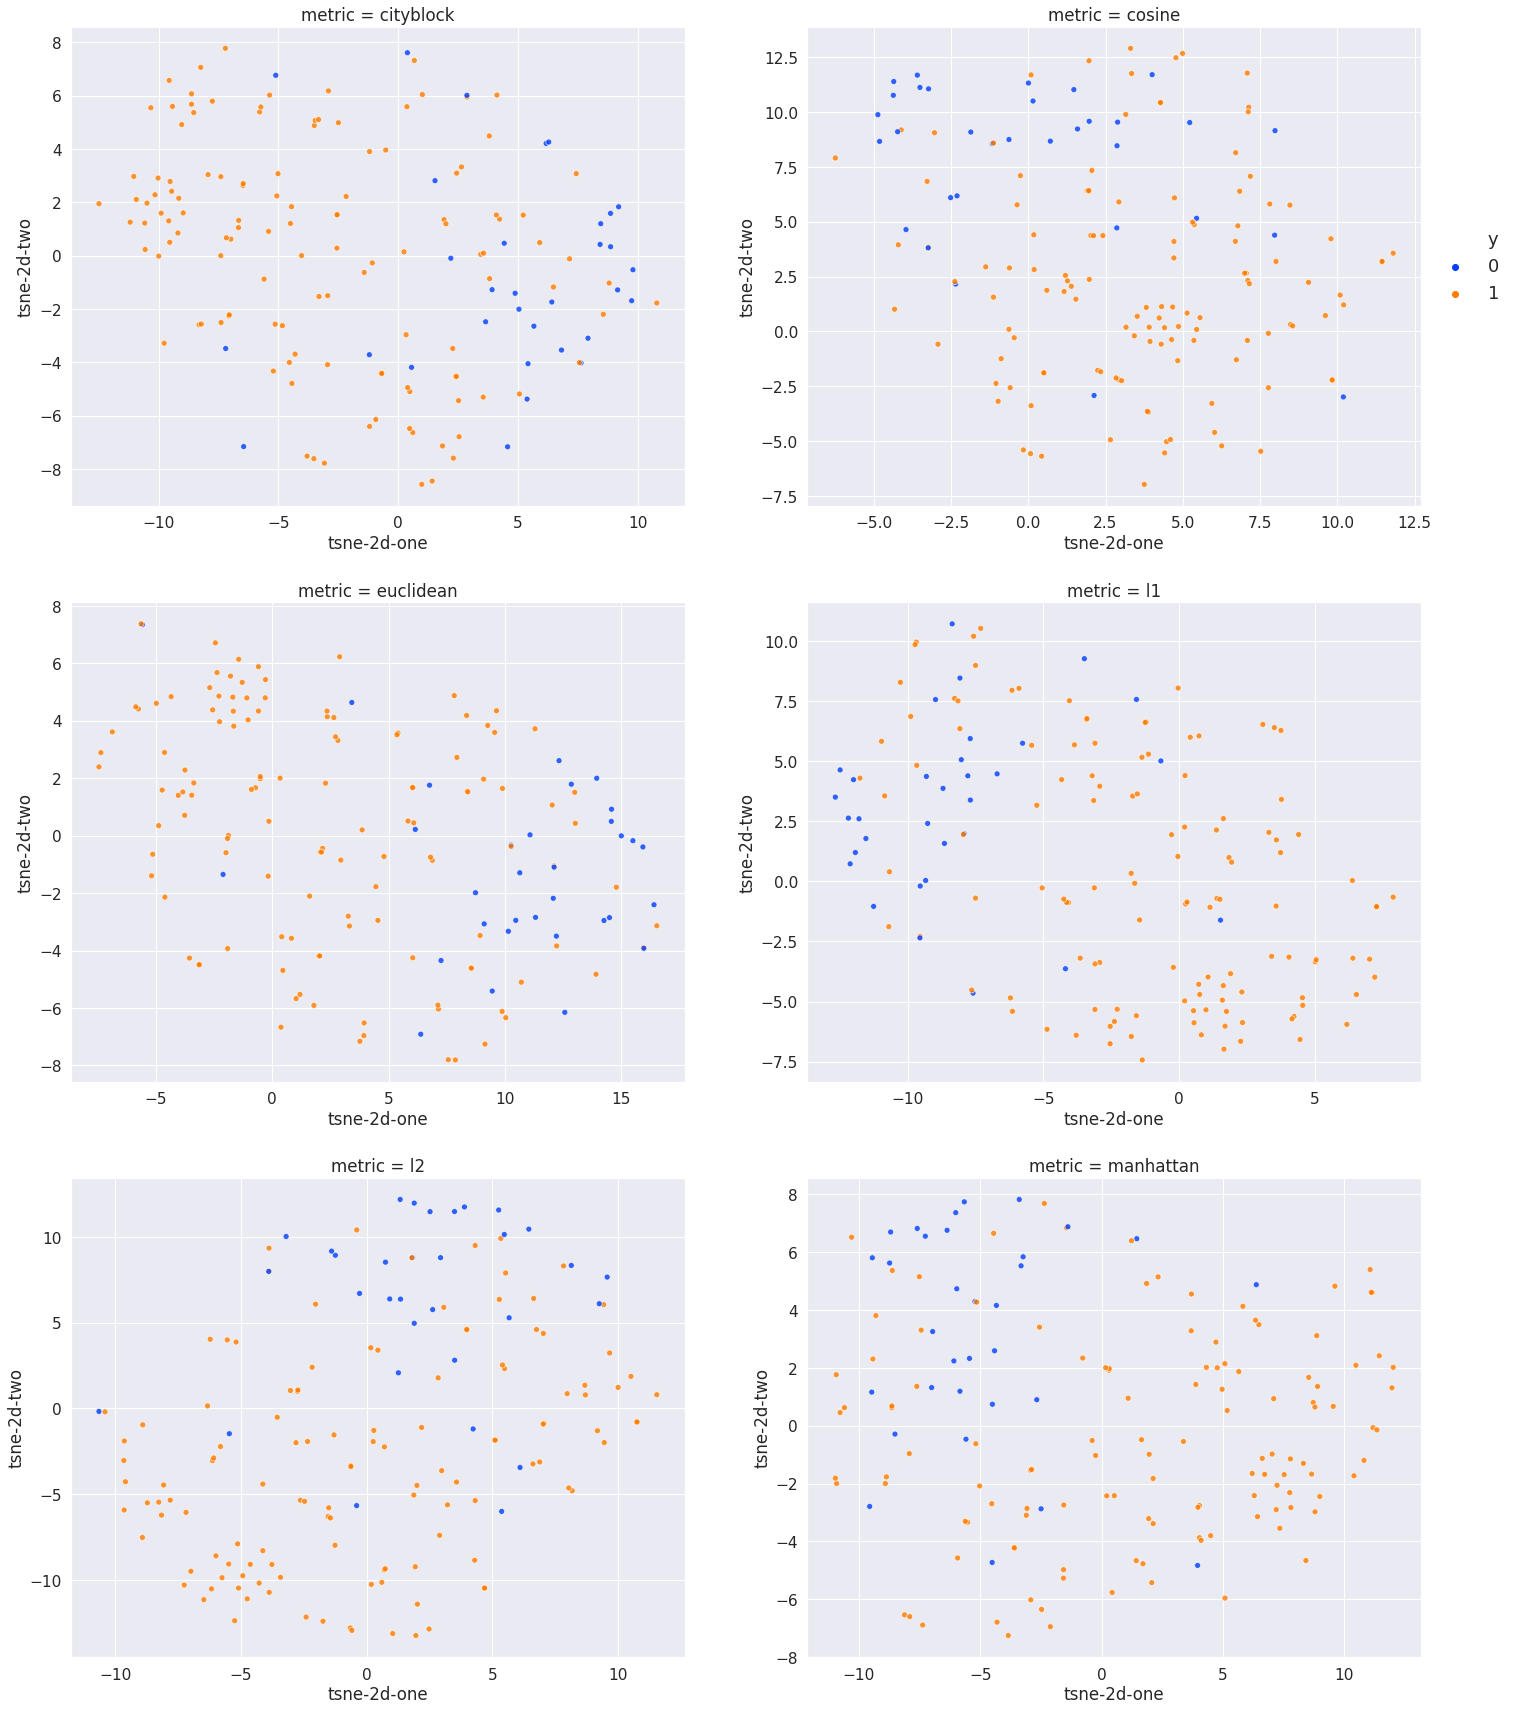

In [11]:
m = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
arr = []
for elem in m:
    x_embedded = TSNE(n_components=2, metric=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("metric = cityblock")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("metric = cosine")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("metric = euclidean")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("metric = l1")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("metric = l2")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("metric = manhattan")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Early exaggeration

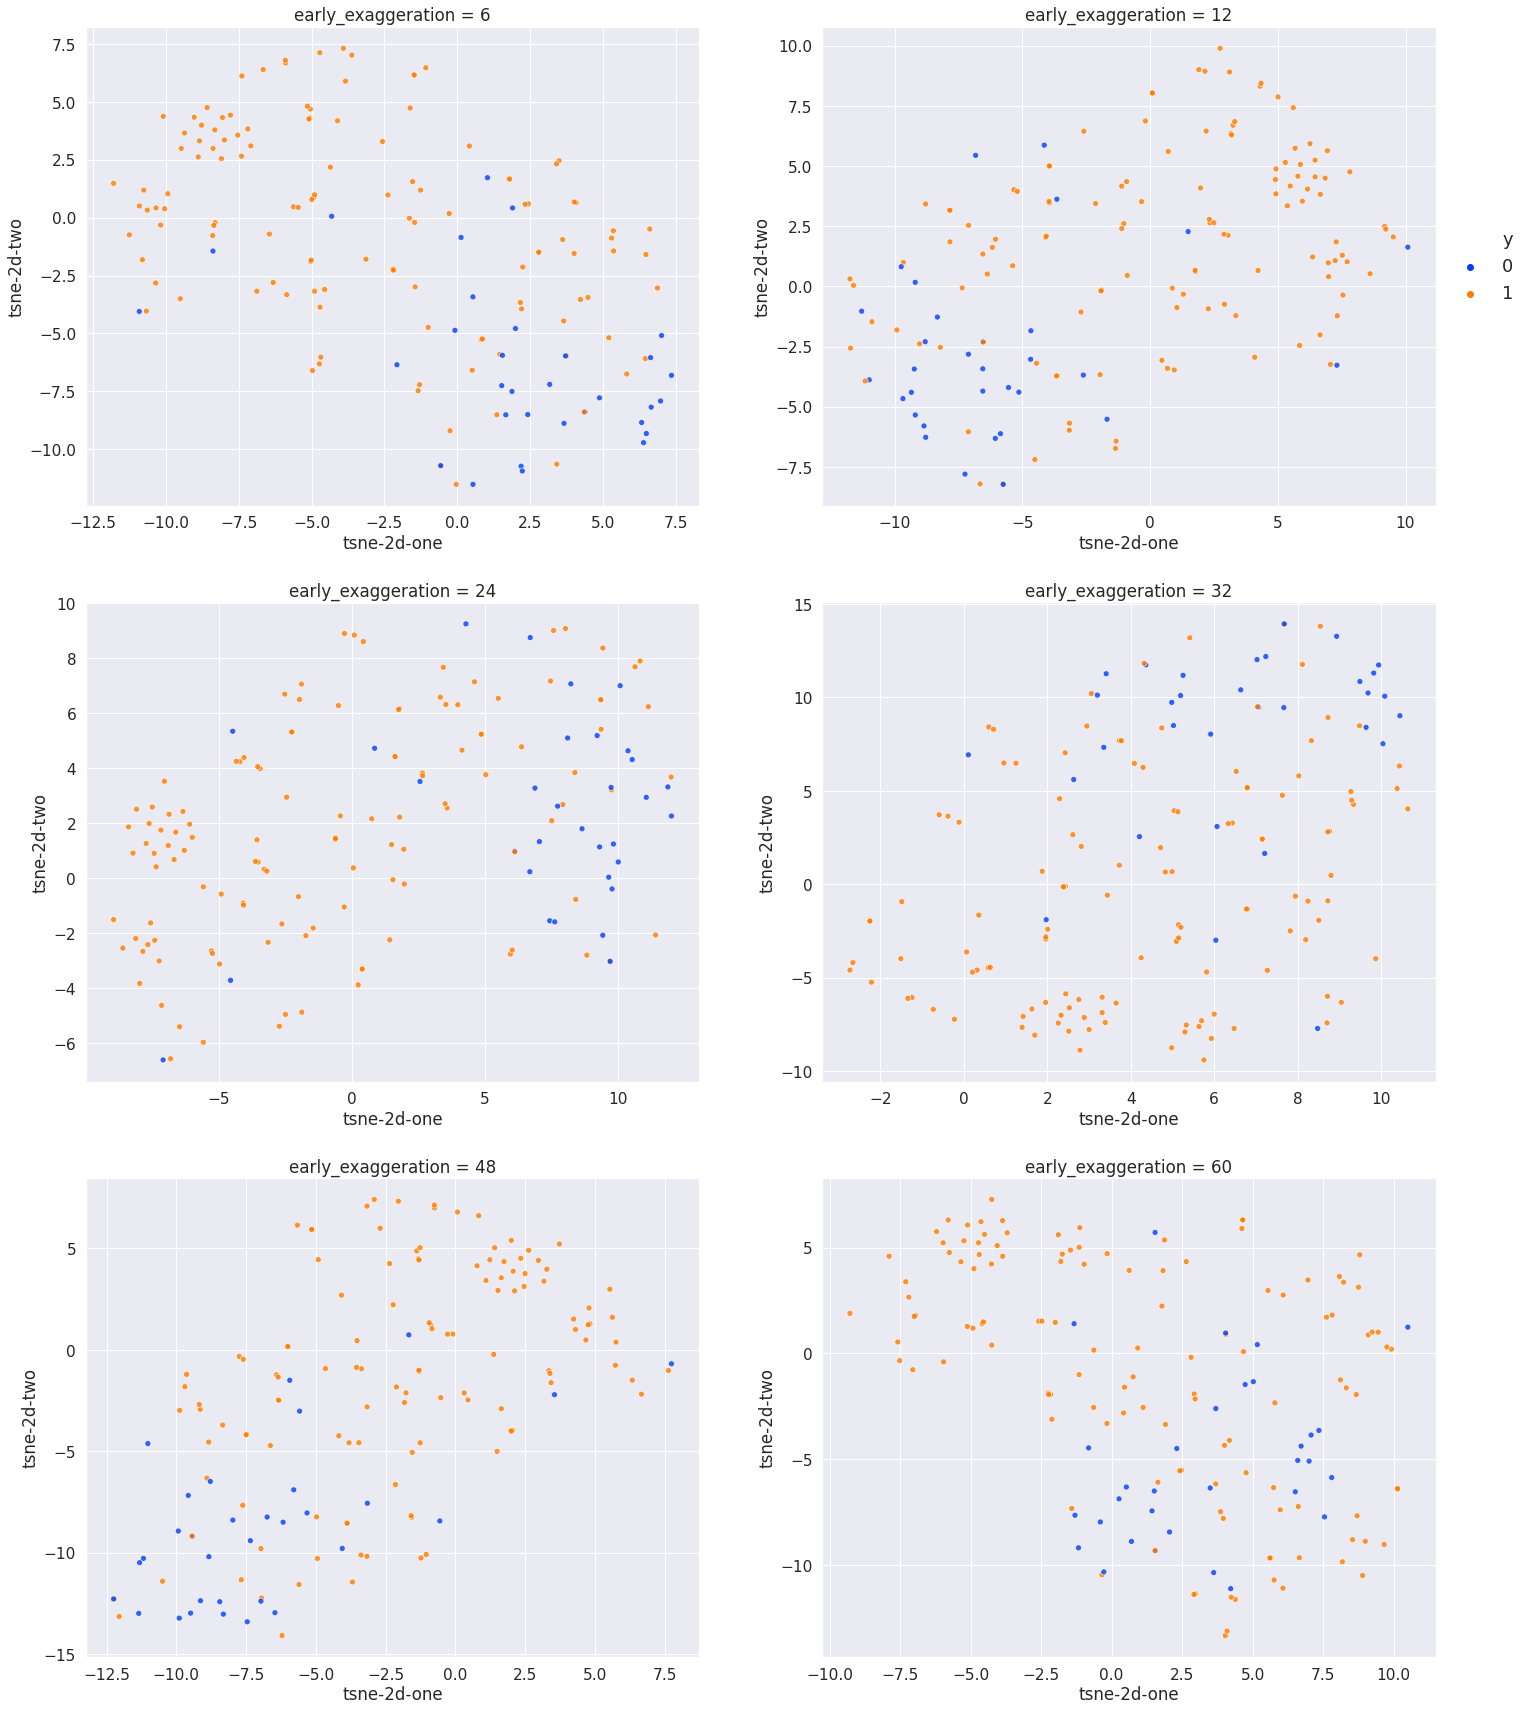

In [12]:
ee = [6, 12, 24, 32, 48, 60]
arr = []
for elem in ee:
    x_embedded = TSNE(n_components=2, early_exaggeration=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("early_exaggeration = 6")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("early_exaggeration = 12")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("early_exaggeration = 24")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("early_exaggeration = 32")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("early_exaggeration = 48")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("early_exaggeration = 60")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Построение графика с комбинацией различных параметров алгоритма t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 155 samples in 0.000s...
[t-SNE] Computed neighbors for 155 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 155 / 155
[t-SNE] Mean sigma: 0.898091
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.631138
[t-SNE] KL divergence after 1300 iterations: 0.395773


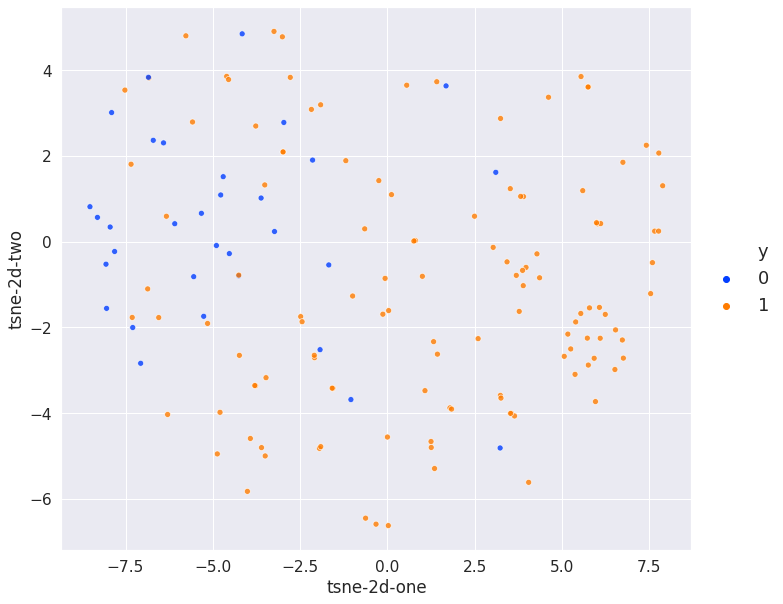

In [13]:
x_embedded = TSNE(n_components=2, verbose=1, perplexity=40,
                  early_exaggeration=12, metric='euclidean',
                  learning_rate=100, n_iter=2000).fit_transform(x)

x_df = pd.DataFrame()
x_df['tsne-2d-one'] = x_embedded[:, 0]
x_df['tsne-2d-two'] = x_embedded[:, 1]
x_df['y'] = y

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=x_df, legend="full", alpha=0.8)
plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

## UMAP

### Nearest neighbours

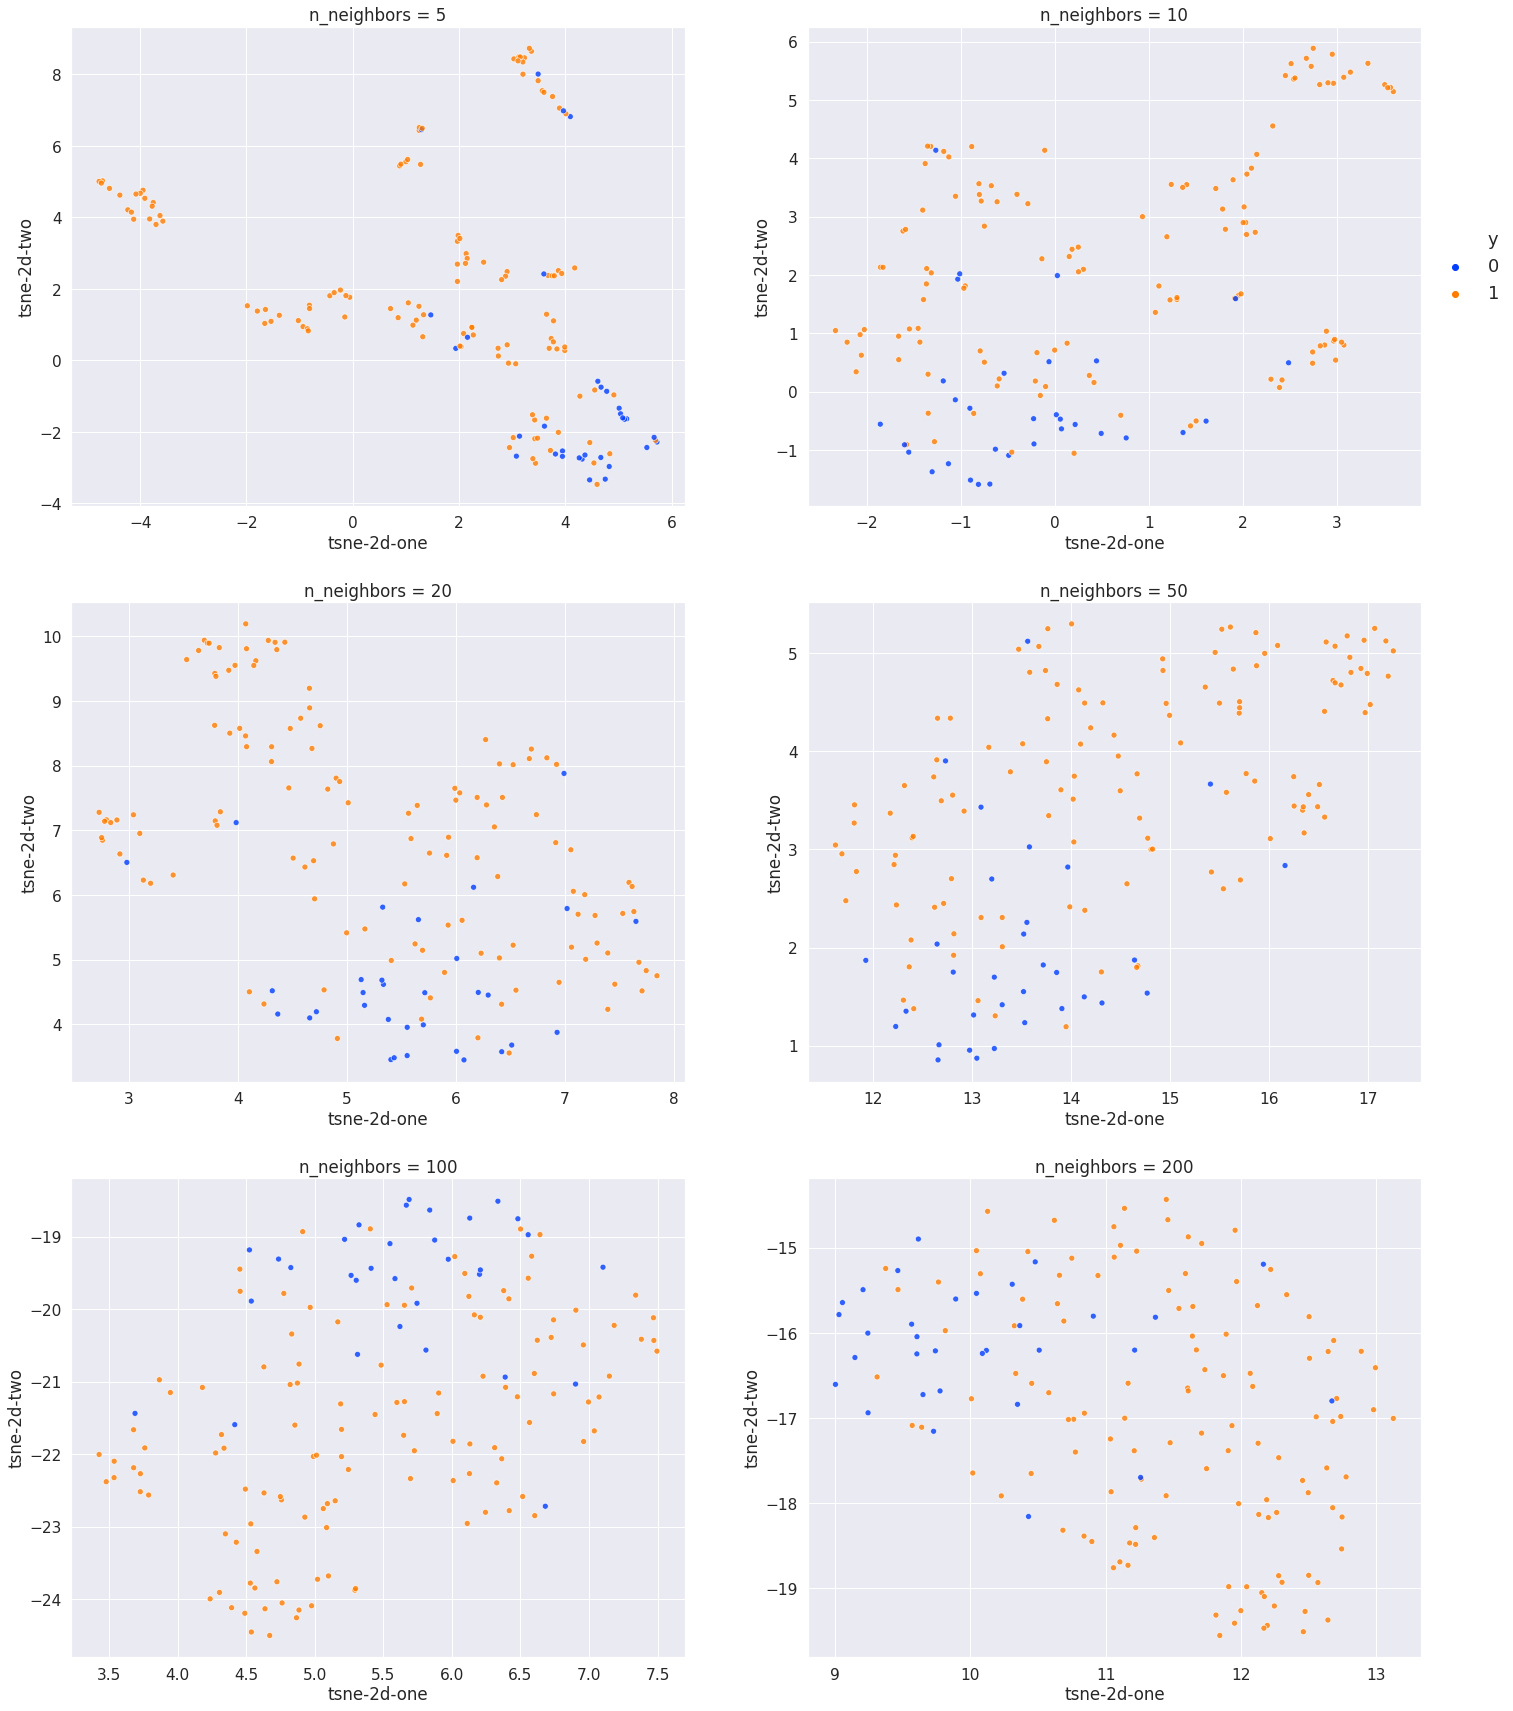

In [14]:
nn = [5, 10, 20, 50, 100, 200]
arr = []
for elem in nn:
    x_embedded = umap.UMAP(n_components=2, n_neighbors=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("n_neighbors = 5")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("n_neighbors = 10")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("n_neighbors = 20")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("n_neighbors = 50")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("n_neighbors = 100")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("n_neighbors = 200")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Minimal distance

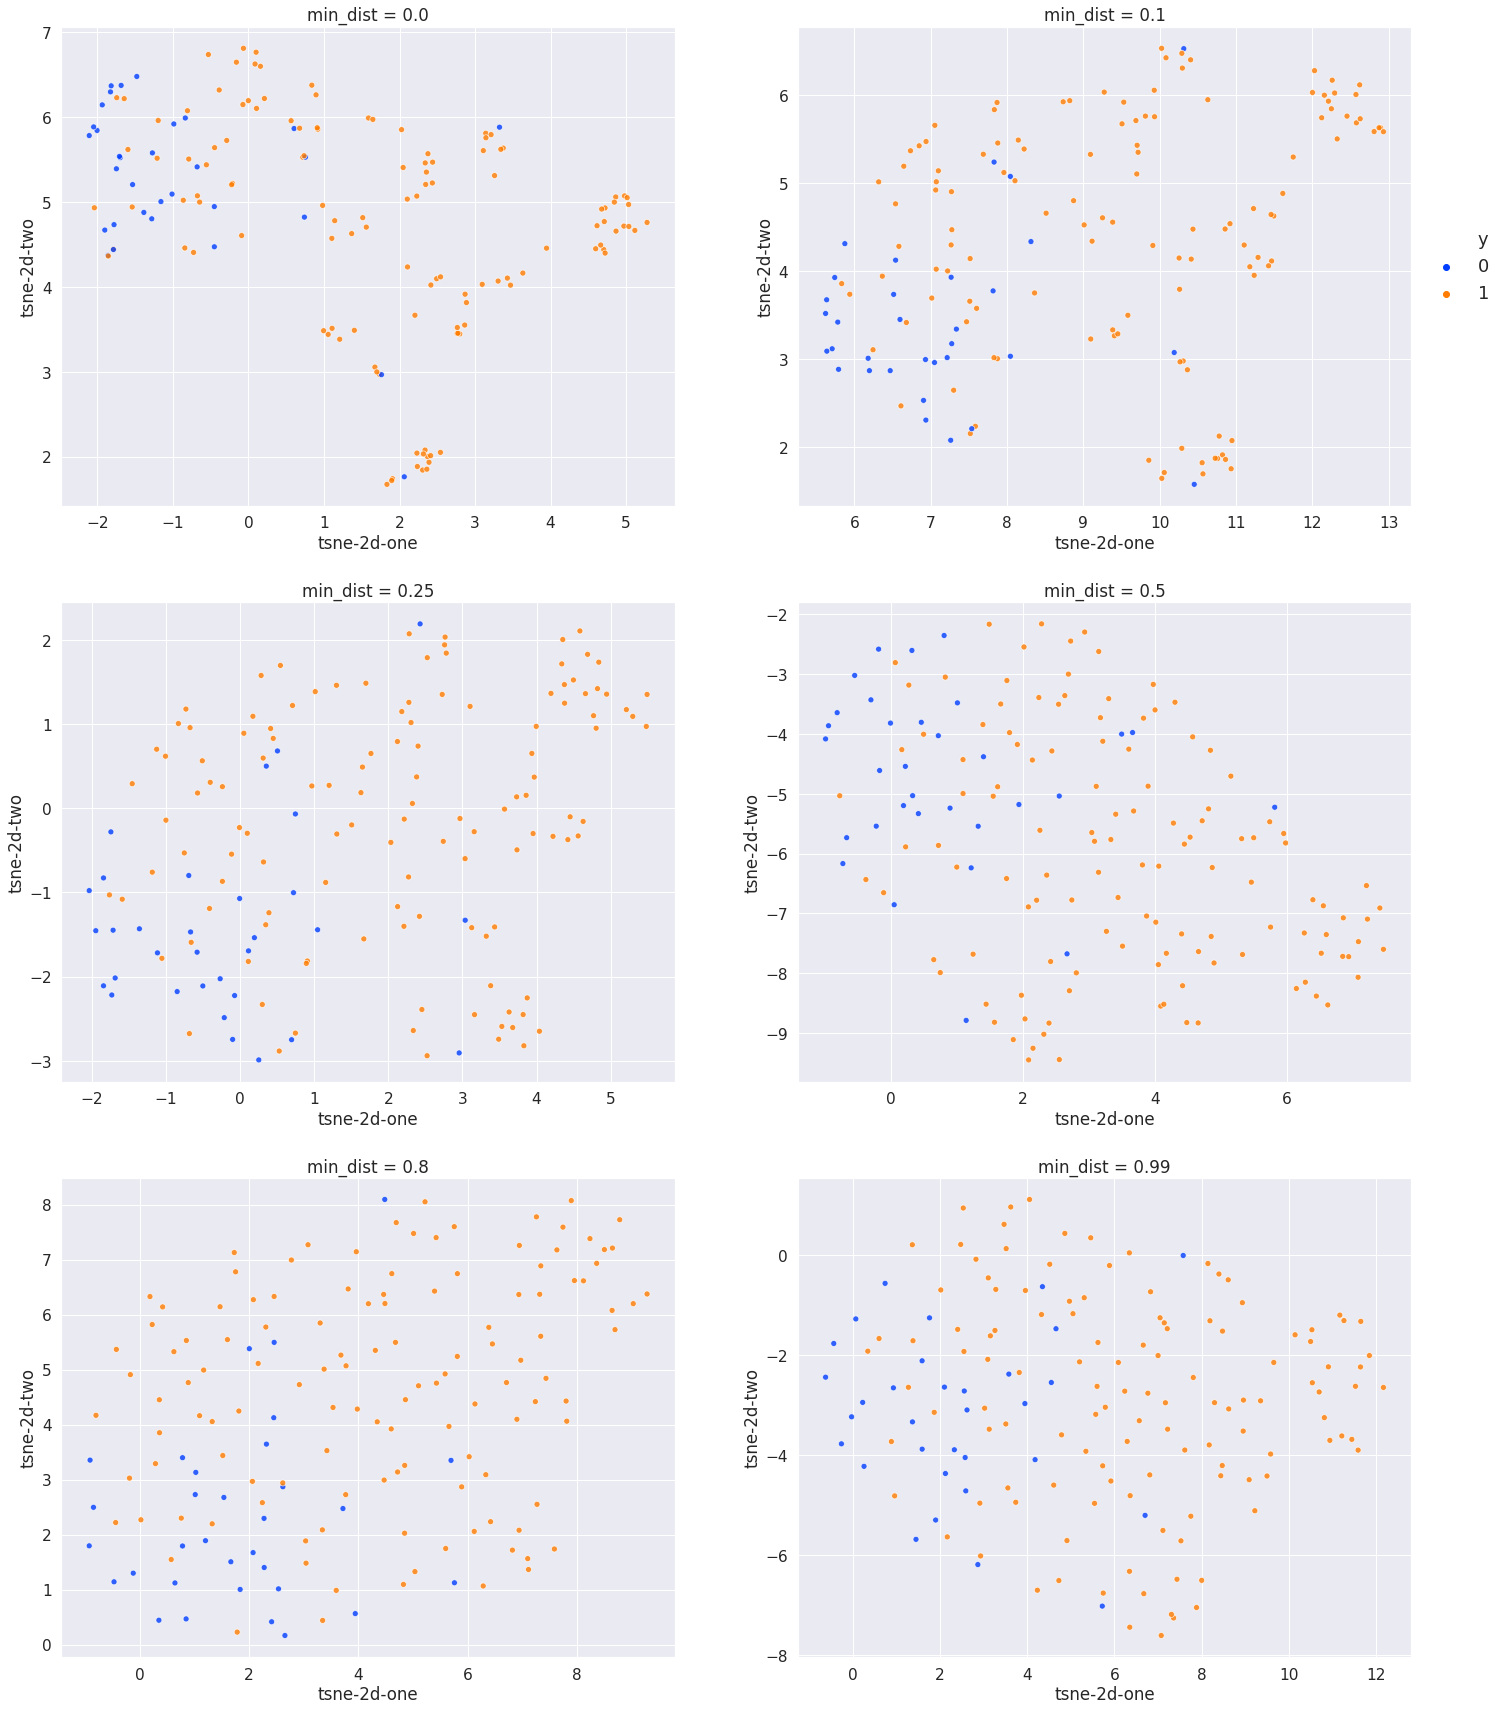

In [15]:
md = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
arr = []
for elem in md:
    x_embedded = umap.UMAP(n_components=2, min_dist=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("min_dist = 0.0")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("min_dist = 0.1")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("min_dist = 0.25")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("min_dist = 0.5")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("min_dist = 0.8")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("min_dist = 0.99")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Metric

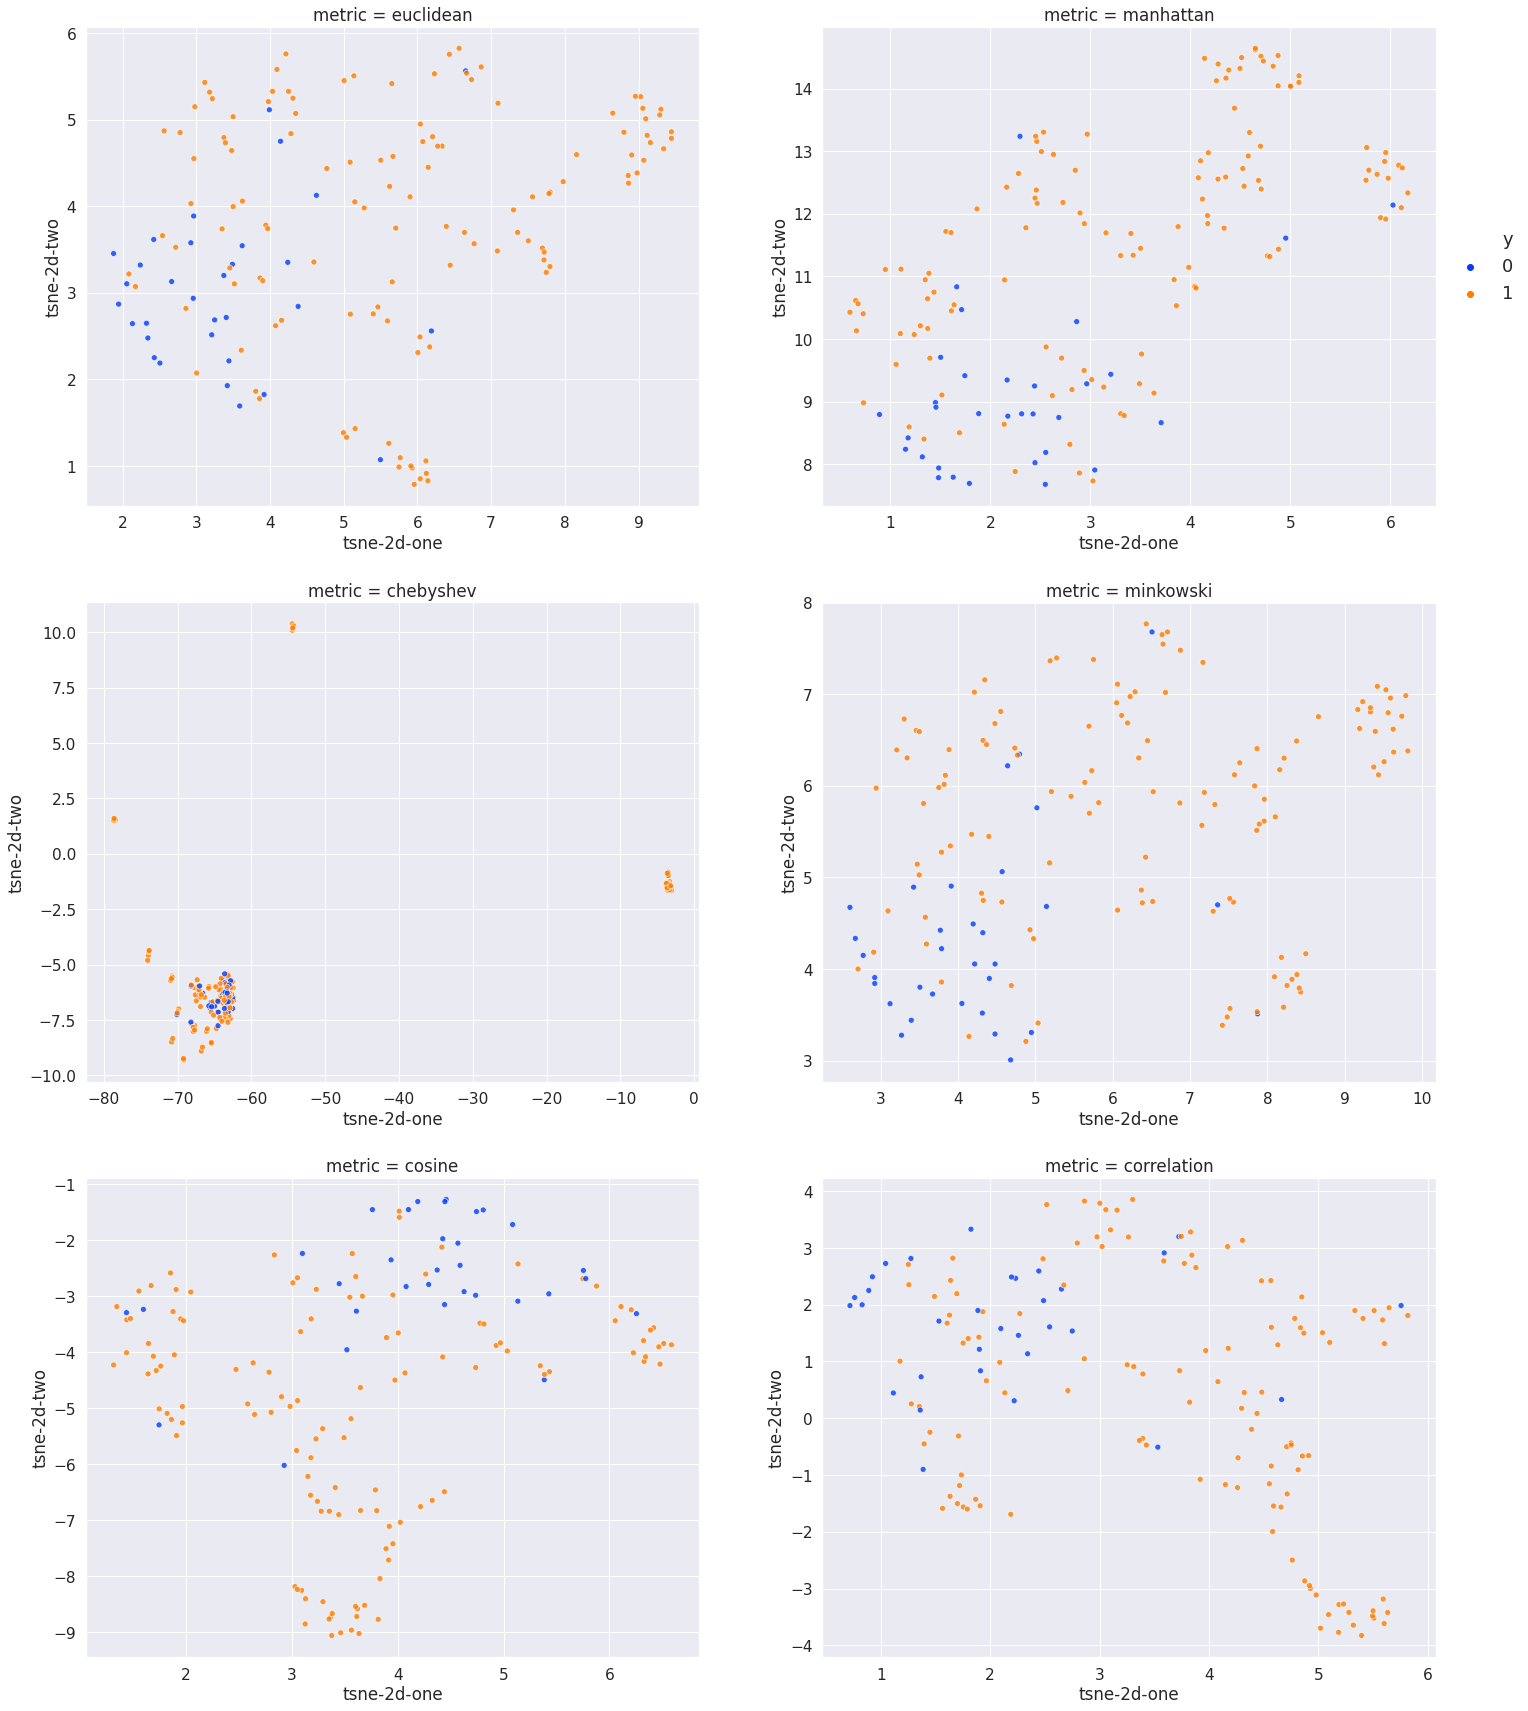

In [16]:
m = ['euclidean', 'manhattan', 'chebyshev',
     'minkowski', 'cosine', 'correlation']
arr = []
for elem in m:
    x_embedded = umap.UMAP(n_components=2, metric=elem).fit_transform(x)

    x_df = pd.DataFrame()
    x_df['tsne-2d-one'] = x_embedded[:, 0]
    x_df['tsne-2d-two'] = x_embedded[:, 1]
    x_df['y'] = y
    arr.append(x_df)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot(3, 2, 1)
ax1.set_title("metric = euclidean")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[0], legend=False, alpha=0.8)

ax2 = plt.subplot(3, 2, 2)
ax2.set_title("metric = manhattan")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[1], legend="full", alpha=0.8)

plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title("metric = chebyshev")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[2], legend=False, alpha=0.8)

ax4 = plt.subplot(3, 2, 4)
ax4.set_title("metric = minkowski")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[3], legend=False, alpha=0.8)

ax5 = plt.subplot(3, 2, 5)
ax5.set_title("metric = cosine")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[4], legend=False, alpha=0.8)

ax6 = plt.subplot(3, 2, 6)
ax6.set_title("metric = correlation")
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y",
                palette=sns.color_palette("bright", 2),
                data=arr[5], legend=False, alpha=0.8)

### Построение графика с комбинацией различных параметров алгоритма UMAP

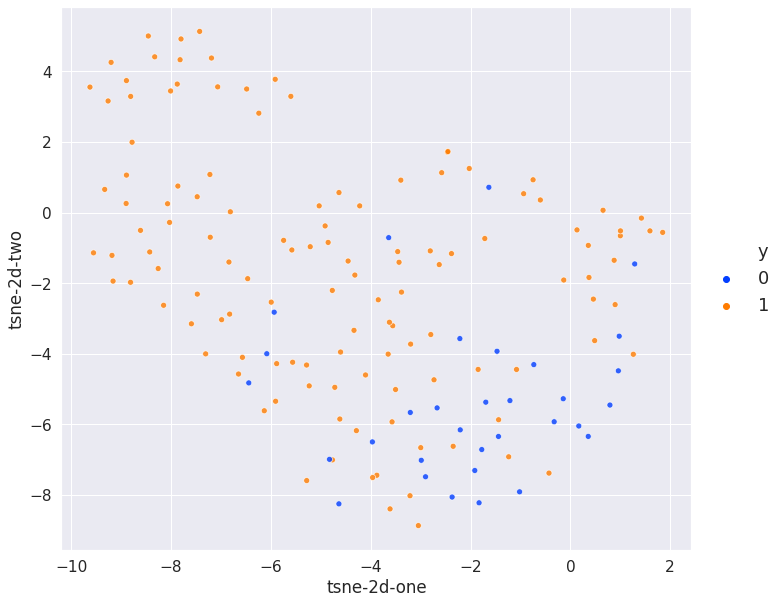

In [17]:
x_embedded = umap.UMAP(n_neighbors=5, min_dist=0.8,
                       metric='euclidean').fit_transform(x)
x_df = pd.DataFrame()
x_df['tsne-2d-one'] = x_embedded[:, 0]
x_df['tsne-2d-two'] = x_embedded[:, 1]
x_df['y'] = y

fig = plt.figure(figsize=(14, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="y", palette=sns.color_palette("bright", 2),
                data=x_df,
                legend="full", alpha=0.8)
plt.legend(frameon=False, bbox_to_anchor=(1, 0.5),
           loc="center left", prop={'size': 18})
plt.subplots_adjust(right=0.75)